# Terraform Workspace Tags

## Overview

In this tutorial, we talk about how to apply Terraform Cloud's new Workspace Tags on all AWS Resources in your Terraform Cloud Workspace.

We will be use Corrigan Neralich's [terraform-cloud-tag-converter] https://github.com/cneralich/terraform-cloud-tag-converter module to pull off this magic.

This Module can dynamically pull any tag values assigned to a Workspace in Terraform Cloud so that they can be passed as `key/value` pairs to Terraform Providers and Resources.

* For any compound tags that are separated by a colon (`:`), this module will split the tag and create a `key/value` pair.
	* For example, if the tag is `key:value`, this module will convert it to `key = "value"`.
* If the tag is a single value, however, this module will use the tag as both the `key` and the `value`.
	* However, but it will prefix the `key` with the string "`tag`" (ex. "`mytag`" would become `tag-mytag = "mytag"`).

We used the [tfe provider](#Create-and-Configure-a-Workspace-with-TFE-Provider) to apply workspace tags to the `hashicat-aws` workspace.

```go
tag_names = ["boss:eljefe", "owner:pphan"]
```

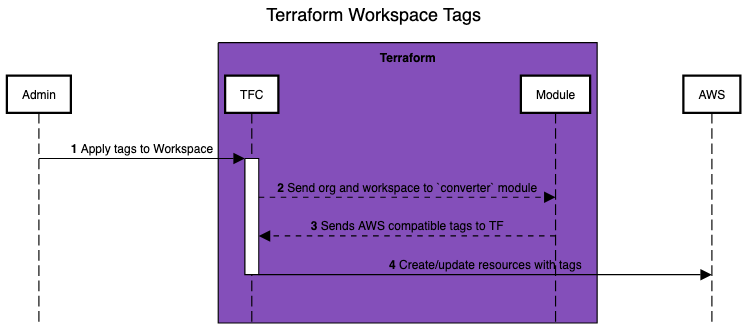

## Prerequisites

* [Terraform Cloud AWS Part 1](Terraform_Cloud_AWS_1.ipynb)
* AWS Provider (v3.38.0 or later)
* TFE Provider (v0.26.1 or later)

---

### Set Main Environment Variables

In [ ]:
export RED="\e[0;31m" YELLOW="\e[0;33m" BLDYELLOW="\e[1;33m" GREEN="\e[0;32m"
export CYAN="\e[0;36m" BLUE="\e[0;34m" WHITE="\e[0;37m" BLDWHITE="\e[1;37m"
export NC="\e[0m"

printf "${GREEN}# Set MAIN_DIR for future reference.${NC}\n"
export MAIN_DIR=${PWD}

Be sure to replace `TF_ORG` and `TF_WS_NAME` with your own values.

In [ ]:
printf "${GREEN}# Set Terraform Variables.${NC}\n"
export TF_ORG="pphan"
export TF_WS_NAME="hashicat-aws"
export TF_ADDR="https://app.terraform.io"
export TF_TOKEN=$(jq -r '.credentials."app.terraform.io".token' ${HOME}/.terraform.d/credentials.tfrc.json)
export HASHICAT_DIR="config/terraform/hashicat-aws"
export TFE_PROVIDER_DIR="config/terraform/tfe-provider"

printf "\n$MAIN_DIR \n $TF_ORG \n $TF_WS_NAME \n $HASHICAT_DIR \n $TFE_PROVIDER_DIR \n"

# Some commands may have sensitive information. Prevent commands starting with a space to be saved to shell history.
HISTCONTROL=ignoreboth # do not save lines that begin with space in history

### AWS Credentials

`terraform` will use credentials set in your environment or through other means as described in the [Terraform documentation](https://www.terraform.io/docs/providers/aws/index.html#environment-variables). This guide will assume you are using the "**Environment Variables**" method.

Add your AWS credentials as two environment variables. Set your `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY` replacing `AAAAAA` with your own values.

In [ ]:
 export AWS_ACCESS_KEY_ID=AAAAAA
 export AWS_SECRET_ACCESS_KEY=AAAAAA
#  export AWS_SESSION_TOKEN=AAAAAA

NOTE: If you use `doormat`, then use this method.

In [ ]:
export account="se_demos_dev" tf_hostname="app.terraform.io"

alias awstfcpush='doormat --smoke-test || doormat -r && doormat aws -a ${account} --tf-push --tf-workspace ${TF_WS_NAME} --tf-organization ${TF_ORG} --tf-hostname ${tf_hostname}'
alias awscredsenv='doormat --smoke-test || doormat -r && eval $(doormat aws -a $account)'

awstfcpush
awscredsenv

**Internal NOTE**: Using `--tf-push` to place variables in workspace. `doormat` locks down the IP so loading env vars into remote agent does not work. 

## Steps

### Use tag converter module to get tags from workspace.

In [ ]:
cat > $HASHICAT_DIR/tags.tf <<EOF
module "tag_converter" {
  source = "github.com/cneralich/terraform-cloud-tag-converter/tag_module"
  tfc_workspace_name = var.TFC_WORKSPACE_NAME
  tfc_workspace_slug = var.TFC_WORKSPACE_SLUG  
}

variable "TFC_WORKSPACE_NAME" {}
variable "TFC_WORKSPACE_SLUG" {}

output "module_tags" {
  value = module.tag_converter.tags
}
EOF

### Modify AWS Provider to add default tags to AWS resources

We will use the module's `tags` outputs inside of the AWS provider stanza.

In [ ]:
sed -i '' '/provider.*\"\aws\"/a \
  default_tags { tags = module.tag_converter.tags } # Pass Provider tags
' $HASHICAT_DIR/main.tf | grep -A3 aws

In [ ]:
terraform -chdir=$HASHICAT_DIR plan

In [ ]:
terraform -chdir=$HASHICAT_DIR apply -auto-approve

## Summary

Here's what we did in this tutorial:

* Used a terraform module to get the tags from a Terraform Cloud Workspace.
	* Converted those tags to AWS friendly tags.
* Configured tags as AWS default tags
	* Leveraged default tags from Terraform AWS Provider (v3.38.0 or later required)

## Clean Up

### Destroy hashicat-aws

In [ ]:
terraform -chdir=$HASHICAT_DIR destroy -auto-approve

### Destroy hashicat-aws workspace

In [ ]:
terraform -chdir=config/terraform/tfe-provider destroy -auto-approve

### Destroy hashicat-aws artifacts

Destroy the cloned `hashicat-aws` directory and the `tfe-provider` directory.

In [ ]:
rm -rf $HASHICAT_DIR
rm -rf config/terraform/tfe-provider